# <center> Кластеризация 4-х канальных электромиографий </center>


Изучение методов возможности кластеризовать ЭМГ различных людей, выполняющие 10 различных действий, по 5 поаторений. Всего данные есть по 40 людям, всего 2000 семплов.

Все эксперименты проводятся на датасете https://data.mendeley.com/datasets/ckwc76xr2z/2

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from loguru import logger

import os
import math

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans

from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA
import scipy


In [2]:
fs = 2000 # Hz
lenght = 1280000 
print(f"В каждом наборе данных запись на {lenght/fs} секунд по 5 повторений, по 10 жестов")

В каждом наборе данных запись на 640.0 секунд по 5 повторений, по 10 жестов


### Предобработка данных

In [3]:
# данные собраны с высокой частотой (2000 Hz) и сильно зашумлены. 
# В качестве первого приближения попробуем брать каждые data_granularity точек из каждого ряда
data_granularity = 10

labels = ['EMG_Filtred_CH1', 'EMG_Filtred_CH2', 'EMG_Filtred_CH3', 'EMG_Filtred_CH4']
df = pd.DataFrame(columns = ["human_n", "gesture", "rep"] + labels)
path = "/Users/zugzvangg/Downloads/ckwc76xr2z-2/sEMG-dataset/filtered/mat/"
# CHANNEL_TO_FIT = "EMG_Filtred_CH1"
CHANNEL_TO_FIT = "EMG_Filtred_CH2"

mySeries = []
namesofMySeries = []

gestures_mapping = {
            0: "REST",
            1: "EXTENSION",
            2: "FLEXION",
            3: "ULNAR DEVIATION",
            4: "RADIAL DEVIATION",
            5: "GRIP",
            6: "ABDUCTION",
            7: "ADDUCTION",
            8: "SUPINATION",
            9: "PRONATION"}

for i in range(1, 41):
# for i in range(1, 5):
    data = scipy.io.loadmat(path + f"{i}_filtered.mat")["data"]
    for rep in range(0, 5):
        if rep==0:
            rep_coeff=4
        elif rep==1:
            rep_coeff=138
        elif rep==2:
            rep_coeff=272
        elif rep==3:
            rep_coeff=406
        elif rep==4:
            rep_coeff=540
        for gesture in range(0, 10):
            
            start_index = (0 + rep_coeff + (gesture * 10)) * fs + 1
            end_index = ((rep_coeff + (gesture * 10)) + 6) * fs
            data_tmp = data[start_index: end_index]
            df_tmp = pd.DataFrame(columns = labels, data = data_tmp)

            mySeries.append(df_tmp[CHANNEL_TO_FIT].values[::data_granularity])
            namesofMySeries.append(f"{gestures_mapping[gesture]}_person{i}_rep{rep}")
            
    logger.info(f"Processed id = {i}")
     
                    


2024-04-26 23:05:06.673 | INFO     | __main__:<cell line: 26>:50 - Processed id = 1
2024-04-26 23:05:06.799 | INFO     | __main__:<cell line: 26>:50 - Processed id = 2
2024-04-26 23:05:06.925 | INFO     | __main__:<cell line: 26>:50 - Processed id = 3
2024-04-26 23:05:07.052 | INFO     | __main__:<cell line: 26>:50 - Processed id = 4
2024-04-26 23:05:07.175 | INFO     | __main__:<cell line: 26>:50 - Processed id = 5
2024-04-26 23:05:07.301 | INFO     | __main__:<cell line: 26>:50 - Processed id = 6
2024-04-26 23:05:07.428 | INFO     | __main__:<cell line: 26>:50 - Processed id = 7
2024-04-26 23:05:07.564 | INFO     | __main__:<cell line: 26>:50 - Processed id = 8
2024-04-26 23:05:07.693 | INFO     | __main__:<cell line: 26>:50 - Processed id = 9
2024-04-26 23:05:07.824 | INFO     | __main__:<cell line: 26>:50 - Processed id = 10
2024-04-26 23:05:07.953 | INFO     | __main__:<cell line: 26>:50 - Processed id = 11
2024-04-26 23:05:08.082 | INFO     | __main__:<cell line: 26>:50 - Process

In [4]:
print("Всего семплов:", len(namesofMySeries))

Всего семплов: 2000


### Примеры ЭМГ из датасета

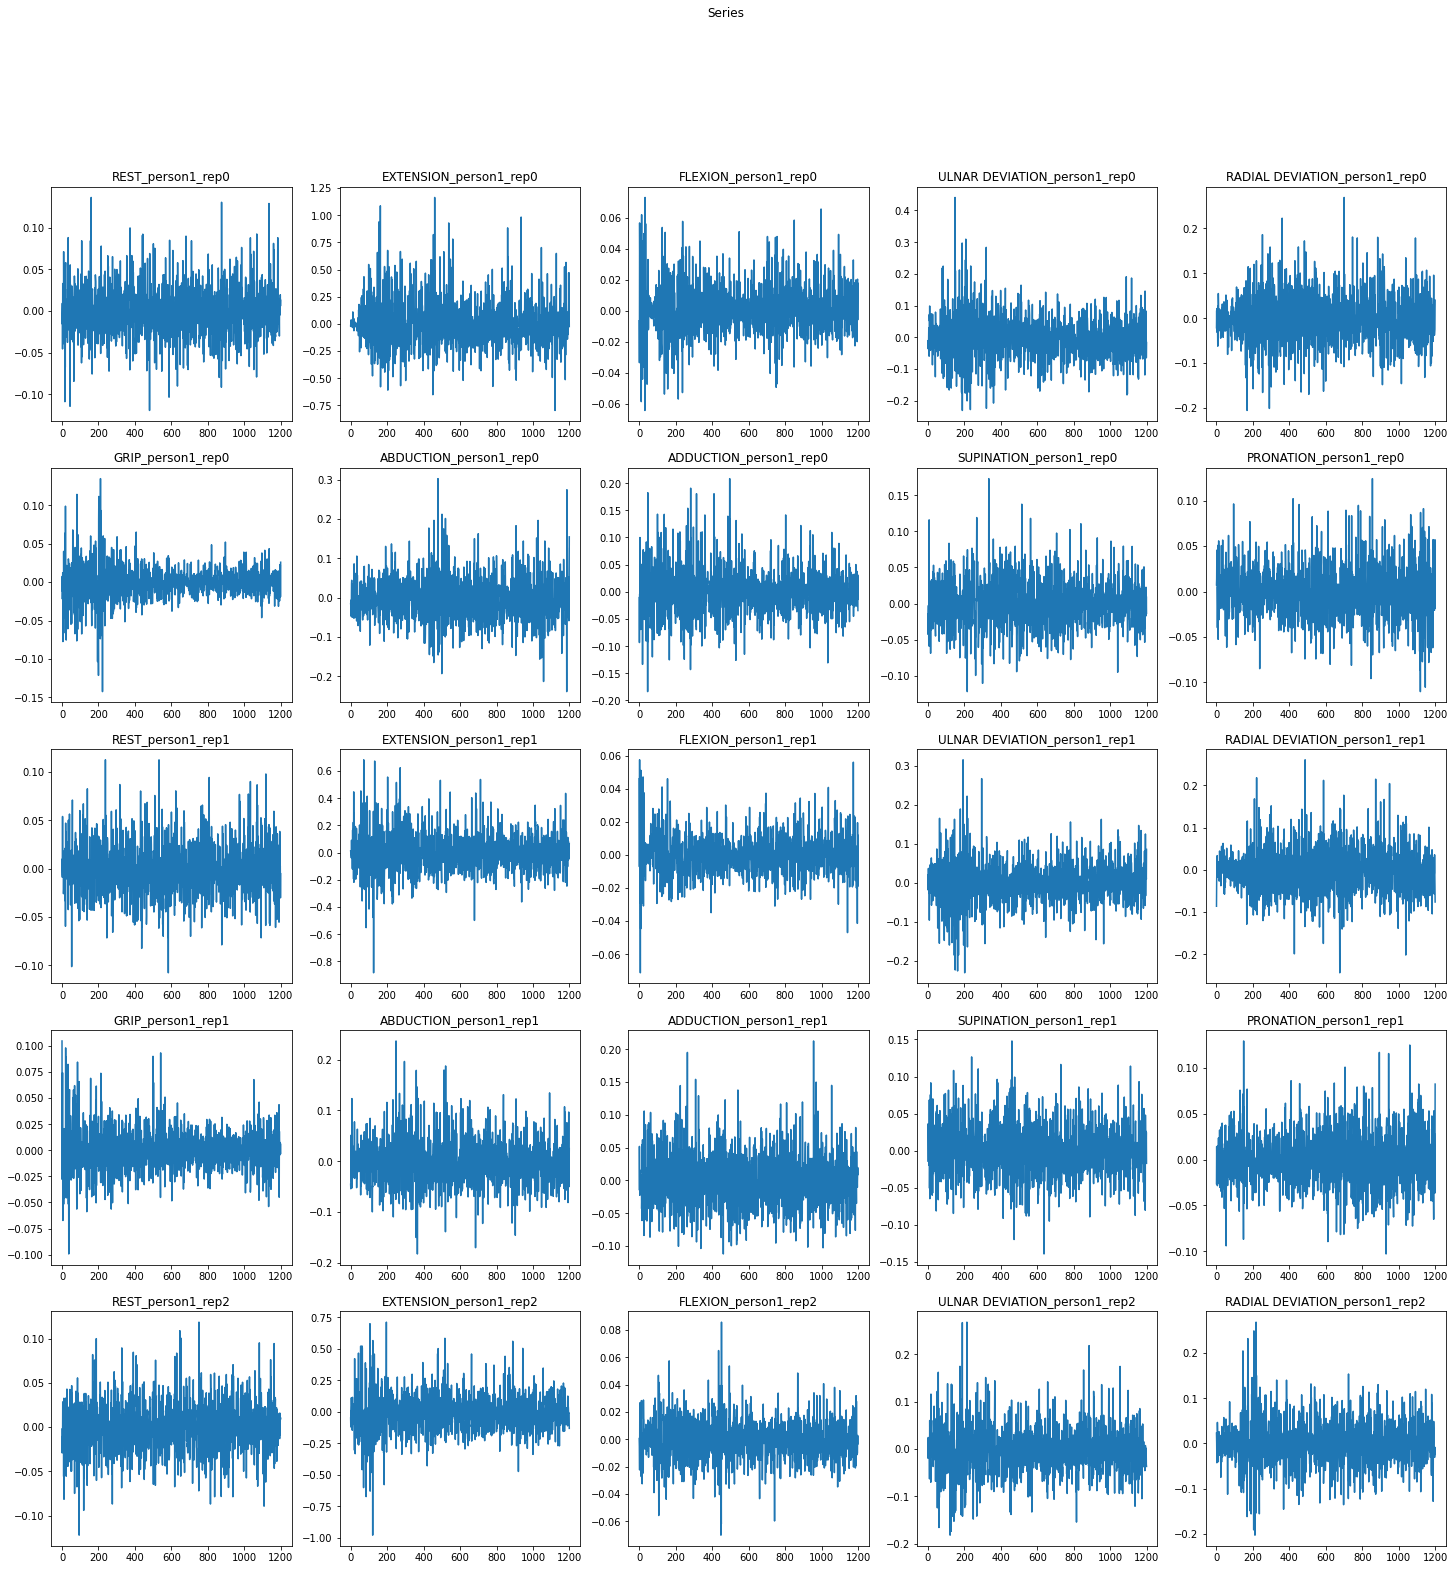

In [5]:
fig, axs = plt.subplots(5,5,figsize=(25,25))
fig.suptitle('Series')
for i in range(5):
    for j in range(5):
        if i*5+j+1>len(mySeries): 
            continue
        axs[i, j].plot(mySeries[i*5+j])
        axs[i, j].set_title(namesofMySeries[i*5+j])
plt.show()

# очень шумные, даже если брать linspace точек

### Предобработка

In [6]:
# сгладим ряды скользящим средним
window_size = int(len(mySeries[0])/5)
window_size

240

In [7]:
def moving_average(a, n):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


for i in range(len(mySeries)):
    mySeries[i] = moving_average(mySeries[i], window_size)

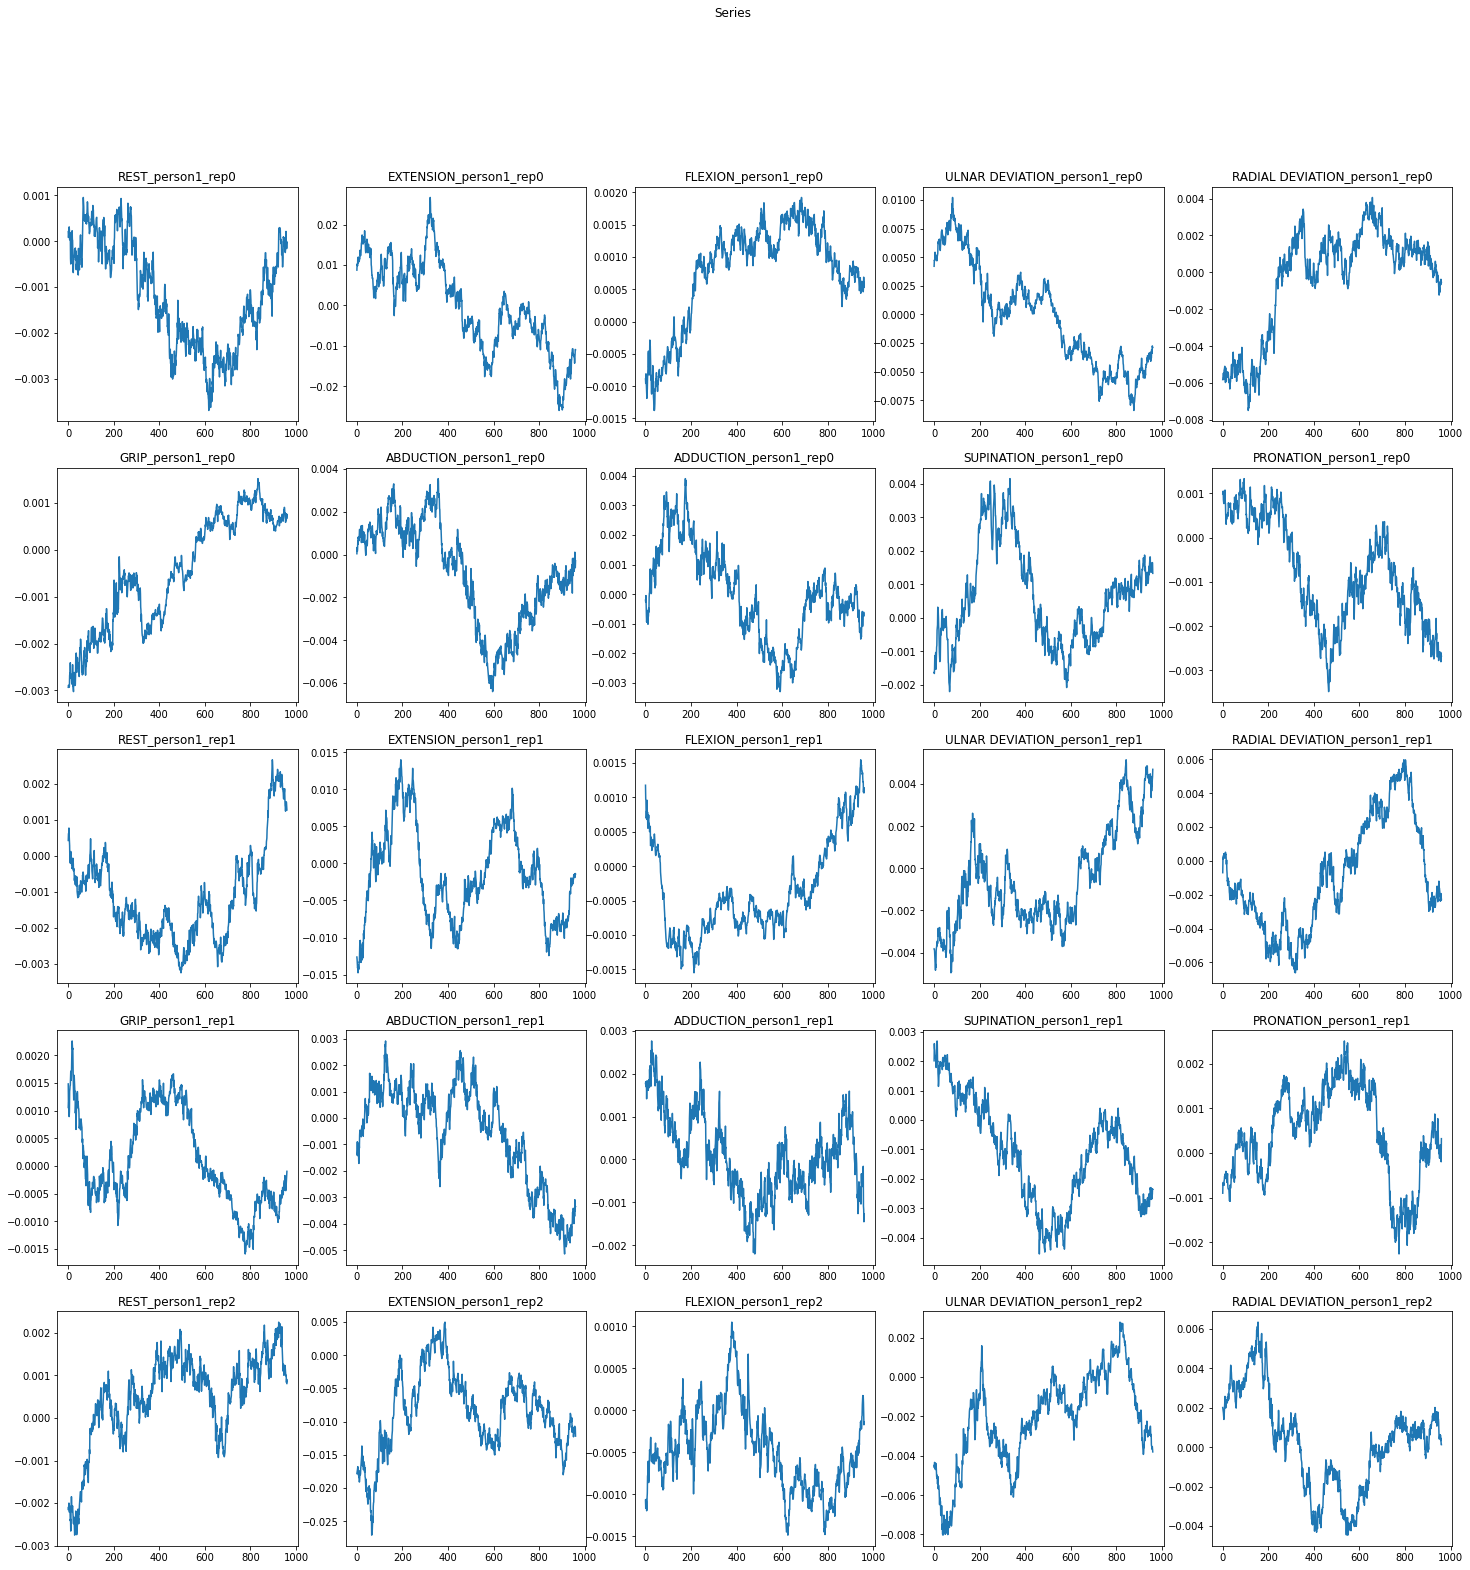

In [8]:
fig, axs = plt.subplots(5,5,figsize=(25,25))
fig.suptitle('Series')
for i in range(5):
    for j in range(5):
        if i*5+j+1>len(mySeries): 
            continue
        axs[i, j].plot(mySeries[i*5+j])
        axs[i, j].set_title(namesofMySeries[i*5+j])
plt.show()

### KNN

In [9]:
np.random.seed(42)
cluster_count = 10
km = TimeSeriesKMeans(n_clusters=cluster_count, max_iter=100)
labels = km.fit_predict(mySeries)

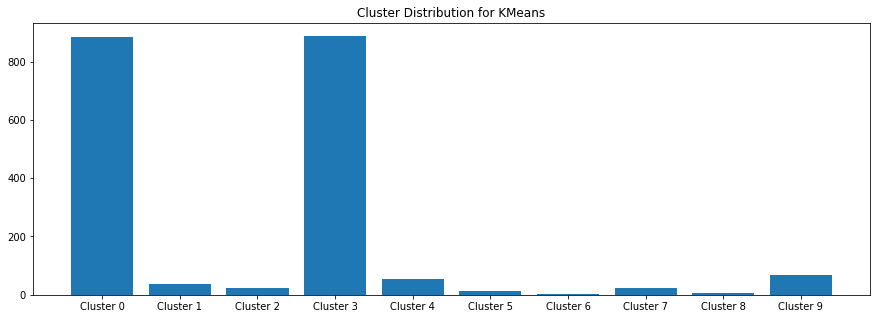

In [10]:
cluster_c = [len(labels[labels==i]) for i in range(cluster_count)]
cluster_n = ["Cluster "+str(i) for i in range(cluster_count)]
plt.figure(figsize=(15,5))
plt.title("Cluster Distribution for KMeans")
plt.bar(cluster_n,cluster_c)
plt.show()

In [11]:
fancy_names_for_labels = [f"Cluster {label}" for label in labels]
knn_result = pd.DataFrame(zip(namesofMySeries,fancy_names_for_labels),
             columns=["Series","Cluster"]).sort_values(by="Cluster")
knn_result["Cluster"].value_counts()

Cluster 3    888
Cluster 0    885
Cluster 9     67
Cluster 4     54
Cluster 1     36
Cluster 7     25
Cluster 2     22
Cluster 5     13
Cluster 8      7
Cluster 6      3
Name: Cluster, dtype: int64

In [12]:
# NOTE: неплохо отличаем EXTENSION, кажого жеста должно быть по 40*5
knn_result[knn_result["Cluster"] == "Cluster 4"]

,Series,Cluster
1471,EXTENSION_person30_rep2,Cluster 4
431,EXTENSION_person9_rep3,Cluster 4
1601,EXTENSION_person33_rep0,Cluster 4
721,EXTENSION_person15_rep2,Cluster 4
1876,ABDUCTION_person38_rep2,Cluster 4
1473,ULNAR DEVIATION_person30_rep2,Cluster 4
1353,ULNAR DEVIATION_person28_rep0,Cluster 4
1781,EXTENSION_person36_rep3,Cluster 4
971,EXTENSION_person20_rep2,Cluster 4
1093,ULNAR DEVIATION_person22_rep4,Cluster 4


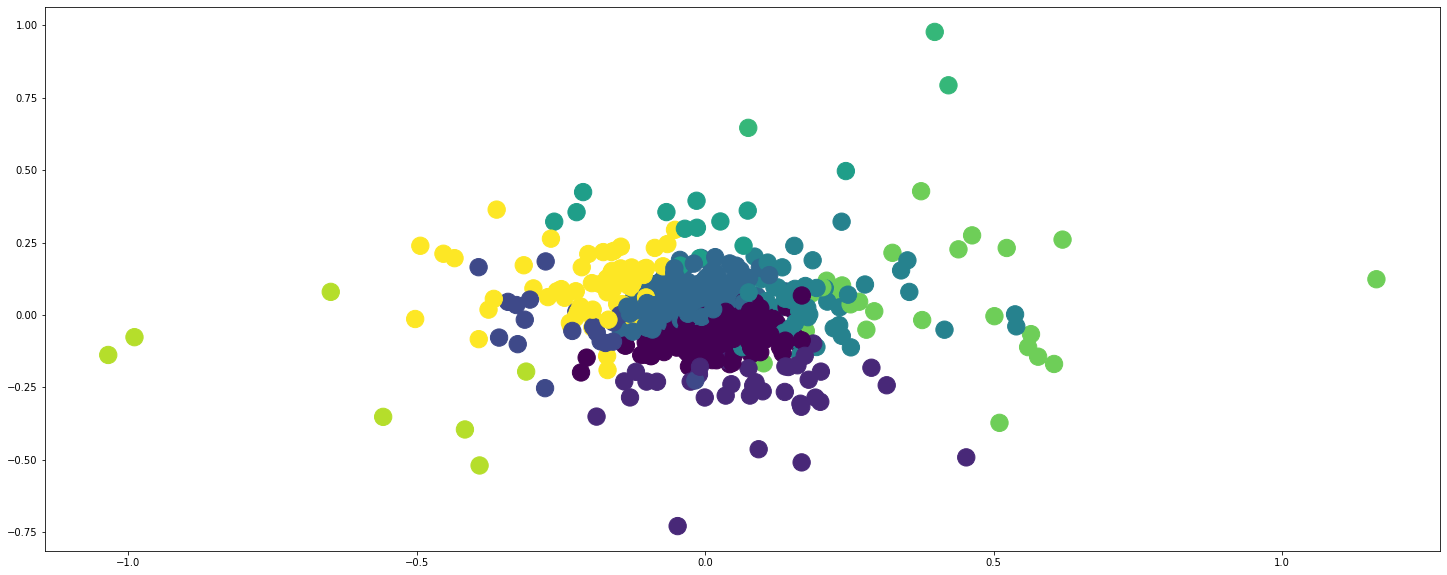

In [13]:
pca = PCA(n_components=2)
mySeries_transformed = pca.fit_transform(mySeries)

plt.figure(figsize=(25,10))
plt.scatter(mySeries_transformed[:,0],mySeries_transformed[:,1], s=300, c=labels)
plt.show()

In [14]:
knn_result["gesture"] = knn_result["Series"].str.split("_", expand = True, n=1)[0]
knn_result_grouped = knn_result.groupby(["gesture"])["Cluster"].unique().reset_index()
knn_result_grouped

,gesture,Cluster
0,ABDUCTION,"[Cluster 0, Cluster 1, Cluster 2, Cluster 3, C..."
1,ADDUCTION,"[Cluster 0, Cluster 1, Cluster 3, Cluster 4, C..."
2,EXTENSION,"[Cluster 0, Cluster 1, Cluster 2, Cluster 3, C..."
3,FLEXION,"[Cluster 0, Cluster 1, Cluster 3, Cluster 9]"
4,GRIP,"[Cluster 0, Cluster 1, Cluster 3, Cluster 4, C..."
5,PRONATION,"[Cluster 0, Cluster 1, Cluster 3, Cluster 4, C..."
6,RADIAL DEVIATION,"[Cluster 0, Cluster 1, Cluster 3, Cluster 4, C..."
7,REST,"[Cluster 0, Cluster 1, Cluster 3, Cluster 9]"
8,SUPINATION,"[Cluster 0, Cluster 3, Cluster 9]"
9,ULNAR DEVIATION,"[Cluster 0, Cluster 1, Cluster 2, Cluster 3, C..."
